In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from collections import defaultdict
from statistics import stdev, mean
from scipy.optimize import minimize
from scipy.spatial import ConvexHull, convex_hull_plot_2d

In [10]:
# download 2024 Nasdaq-100 daily closing prices
url = 'https://en.m.wikipedia.org/wiki/Nasdaq-100'
df_nasdaq_100_list = pd.read_html(url, attrs={'id': "constituents"}, index_col='Symbol')[0]
tickers = list(df_nasdaq_100_list.index)
df_nasdaq_100 = yf.download(tickers, '2024-01-01', '2024-12-31')
df_nasdaq_100.head()

[*********************100%***********************]  99 of 101 completed

101 Failed downloads:
['ARM', 'ABNB', 'MSTR', 'KHC', 'AEP', 'ODFL', 'IDXX', 'CPRT', 'MAR', 'NFLX', 'DDOG', 'LRCX', 'DXCM', 'NXPI', 'TTD', 'BKR', 'AMD', 'MRVL', 'REGN', 'SBUX', 'INTU', 'ASML', 'VRSK', 'KDP', 'MU', 'EA', 'GILD', 'FANG', 'VRTX', 'SNPS', 'AMAT', 'HON', 'AMZN', 'PEP', 'GOOG', 'EXC', 'INTC', 'BIIB', 'ROP', 'TTWO', 'AMGN', 'CSGP', 'DASH', 'GEHC', 'CCEP', 'MDLZ', 'ZS', 'ANSS', 'ADP', 'AZN', 'MDB', 'CDW', 'CHTR', 'MCHP', 'BKNG', 'CRWD', 'MELI', 'CSCO', 'ADSK', 'ORLY', 'ADI', 'CTSH', 'ROST', 'PDD', 'NVDA', 'CDNS', 'CMCSA', 'APP', 'CEG', 'KLAC', 'CSX', 'COST', 'PYPL', 'AXON', 'TXN', 'META', 'XEL', 'WDAY', 'FTNT', 'QCOM', 'LULU', 'CTAS', 'MNST', 'AVGO', 'TMUS', 'AAPL', 'PLTR', 'MSFT', 'TEAM', 'ISRG', 'ADBE', 'TSLA', 'PCAR', 'GOOGL', 'FAST', 'WBD', 'PANW', 'LIN', 'GFS']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
['PAYX']: ChunkedEncodingError(ProtocolError("Connection broken: InvalidChunkLen

Empty DataFrame
Columns: [(Adj Close, AAPL), (Adj Close, ABNB), (Adj Close, ADBE), (Adj Close, ADI), (Adj Close, ADP), (Adj Close, ADSK), (Adj Close, AEP), (Adj Close, AMAT), (Adj Close, AMD), (Adj Close, AMGN), (Adj Close, AMZN), (Adj Close, ANSS), (Adj Close, APP), (Adj Close, ARM), (Adj Close, ASML), (Adj Close, AVGO), (Adj Close, AXON), (Adj Close, AZN), (Adj Close, BIIB), (Adj Close, BKNG), (Adj Close, BKR), (Adj Close, CCEP), (Adj Close, CDNS), (Adj Close, CDW), (Adj Close, CEG), (Adj Close, CHTR), (Adj Close, CMCSA), (Adj Close, COST), (Adj Close, CPRT), (Adj Close, CRWD), (Adj Close, CSCO), (Adj Close, CSGP), (Adj Close, CSX), (Adj Close, CTAS), (Adj Close, CTSH), (Adj Close, DASH), (Adj Close, DDOG), (Adj Close, DXCM), (Adj Close, EA), (Adj Close, EXC), (Adj Close, FANG), (Adj Close, FAST), (Adj Close, FTNT), (Adj Close, GEHC), (Adj Close, GFS), (Adj Close, GILD), (Adj Close, GOOG), (Adj Close, GOOGL), (Adj Close, HON), (Adj Close, IDXX), (Adj Close, INTC), (Adj Close, INTU), (Adj Close, ISRG), (Adj Close, KDP), (Adj Close, KHC), (Adj Close, KLAC), (Adj Close, LIN), (Adj Close, LRCX), (Adj Close, LULU), (Adj Close, MAR), (Adj Close, MCHP), (Adj Close, MDB), (Adj Close, MDLZ), (Adj Close, MELI), (Adj Close, META), (Adj Close, MNST), (Adj Close, MRVL), (Adj Close, MSFT), (Adj Close, MSTR), (Adj Close, MU), (Adj Close, NFLX), (Adj Close, NVDA), (Adj Close, NXPI), (Adj Close, ODFL), (Adj Close, ON), (Adj Close, ORLY), (Adj Close, PANW), (Adj Close, PAYX), (Adj Close, PCAR), (Adj Close, PDD), (Adj Close, PEP), (Adj Close, PLTR), (Adj Close, PYPL), (Adj Close, QCOM), (Adj Close, REGN), (Adj Close, ROP), (Adj Close, ROST), (Adj Close, SBUX), (Adj Close, SNPS), (Adj Close, TEAM), (Adj Close, TMUS), (Adj Close, TSLA), (Adj Close, TTD), (Adj Close, TTWO), (Adj Close, TXN), (Adj Close, VRSK), (Adj Close, VRTX), (Adj Close, WBD), (Adj Close, WDAY), (Adj Close, XEL), ...]
Index: []

[0 rows x 606 columns]

In [3]:
def portfolio_variance(w, cov_matrix):
    return w.T @ cov_matrix @ w

def min_variance_portfolio(means, cov_matrix, target_return):
    n = len(means)
    w0 = np.ones(n) / n # initial guess: equal weights
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},            # sum of weights = 1
        {'type': 'eq', 'fun': lambda w: means @ w - target_return} # target return: mu w
    ]
    bounds = [(0, 1)] * n # no short selling: weights >= 0
    # solve the optimization problem
    result = minimize(portfolio_variance, w0, args=(cov_matrix,),
                      constraints=constraints, bounds=bounds,
                      options={'ftol': 1e-9, 'maxiter': 1000})
    return result.x if result.success else None

# given per ticker returns in ar for a trading window, compute and return
# the volatility and return for a portfolio in this trading window
def portfolio_return(ar, portfolio_weights):
    num_tickers = len(ar[0])
    portfolio_returns = []
    for day in range(len(ar)):
        daily_return = sum([portfolio_weights[i]*ar[day][i] for i in range(num_tickers)])
        portfolio_return = np.log(daily_return) # portfolio log return for given day
        portfolio_returns.append(portfolio_return)
    std = np.sqrt(np.var(portfolio_returns))
    avg = np.mean(portfolio_returns)
    return std, avg

def plot_portfolios(df_logr, bare, portfolios, title, portfolio_point_size=8):
    # set up plot
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.axhline(0, linestyle='--')
    plt.xlabel('log volatility')
    plt.ylabel('log return')
    plt.title(title)
    plt.xlim((0, 0.05))
    plt.ylim((-0.004, 0.009))
    # plot original points with labels
    xs, ys = bare
    ax.scatter(xs, ys)
    for i, ticker in enumerate(df_logr.columns.values):
        ax.annotate(ticker, (xs[i], ys[i]))
    # plot portfolio points
    #ax.scatter(pxs, pys, zorder=0, s=portfolio_point_size)
    colors = ['orange', 'magenta']
    for i, p in enumerate(portfolios):
        ax.plot(p[0], p[1], marker=".", markersize=portfolio_point_size, color=colors[i])

In [4]:
df_logr = np.log(df_nasdaq_100['Adj Close']).diff()[1:]
df_r = np.exp(df_logr)

# compute per-ticker log mean and variance
xs = [np.sqrt(df_logr[ticker].var()) for ticker in df_logr.columns.values]
ys = [df_logr[ticker].mean() for ticker in df_logr.columns.values]
bare = xs, ys

means = df_r.mean()
cov_matrix = df_r.cov()
#cov_matrix += np.eye(len(cov_matrix)) * 1e-5

efficient_frontier = []
for tr in np.linspace(means.min(), means.max(), 100):
    portfolio = min_variance_portfolio(means, cov_matrix, tr)
    if portfolio is None:
        print(f'CSP failed for target return = {tr}')
        continue
    efficient_frontier.append((tr, portfolio))

In [5]:
ar = np.nan_to_num(df_r.to_numpy(), nan=1)
xs, ys = [], []
for _, portfolio in efficient_frontier:
    std, avg = portfolio_return(ar, portfolio)
    xs.append(std)
    ys.append(avg)
portfolios = xs, ys

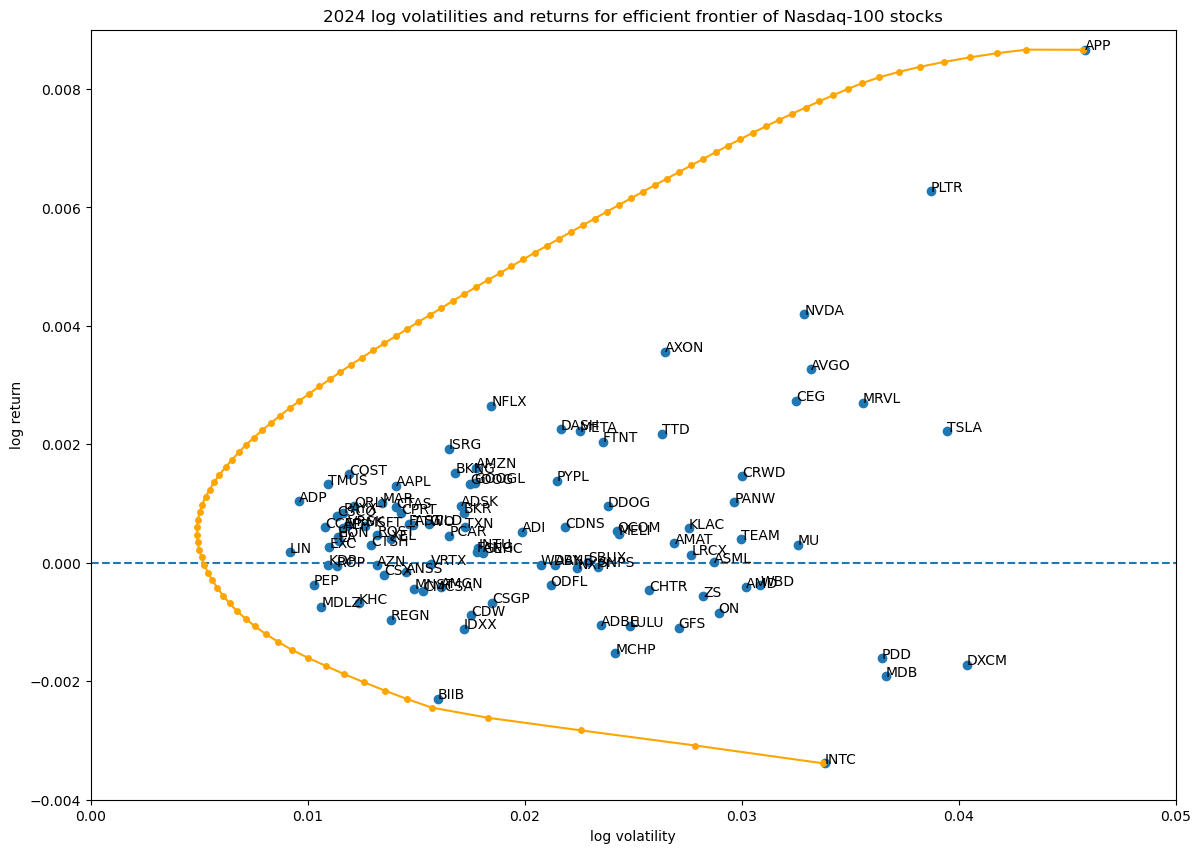

In [6]:
plot_portfolios(df_logr, bare, [portfolios], '2024 log volatilities and returns for efficient frontier of Nasdaq-100 stocks')

In [7]:
portfolios_stocks_only = portfolios

In [8]:
# repeat the same, but first inject the risk-free asset into the portfolio

df_logr = np.log(df_nasdaq_100['Adj Close']).diff()[1:]
risk_free_annual_return = 1.05
risk_free_daily_log_return = np.log(risk_free_annual_return**(1/len(df_logr)))
df_logr.insert(len(df_logr.columns), 'RISKFREE', [risk_free_daily_log_return] * len(df_logr))
df_r = np.exp(df_logr)

xs = [np.sqrt(df_logr[ticker].var()) for ticker in df_logr.columns.values]
ys = [df_logr[ticker].mean() for ticker in df_logr.columns.values]
bare = xs, ys

means = df_r.mean()
cov_matrix = df_r.cov()
efficient_frontier = []
for tr in np.linspace(means.min(), means.max(), 100):
    portfolio = min_variance_portfolio(means, cov_matrix, tr)
    if portfolio is None:
        print(f'CSP failed for target return = {tr}')
        continue
    efficient_frontier.append((tr, portfolio))

ar = np.nan_to_num(df_r.to_numpy(), nan=1)
xs, ys = [], []
for _, portfolio in efficient_frontier:
    std, avg = portfolio_return(ar, portfolio)
    xs.append(std)
    ys.append(avg)
portfolios = xs, ys

/tmp/ipykernel_3223658/1079315409.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_logr.insert(len(df_logr.columns), 'RISKFREE', [risk_free_daily_log_return] * len(df_logr))


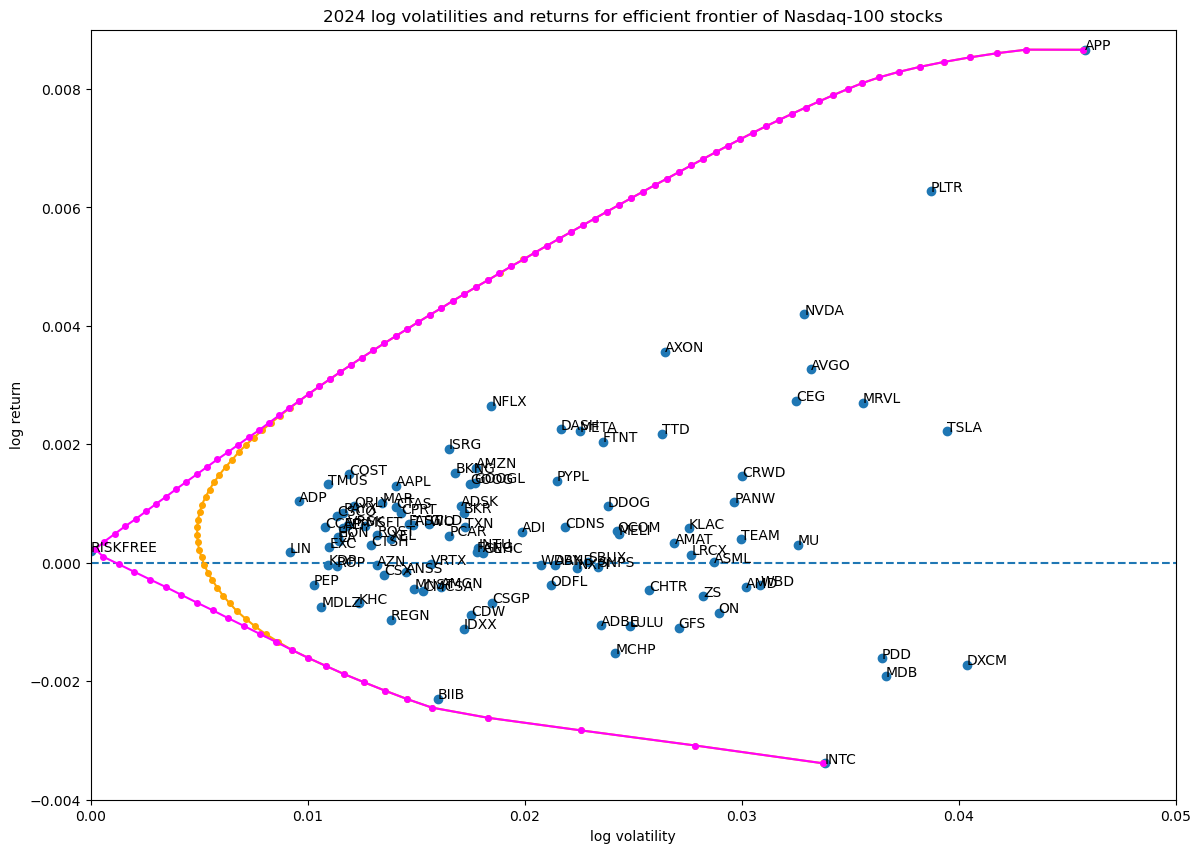

In [9]:
plot_portfolios(df_logr, bare, [portfolios_stocks_only, portfolios], '2024 log volatilities and returns for efficient frontier of Nasdaq-100 stocks')